In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# reading data and put them into matrix form

ratings_df     = pd.read_csv("ml-latest-small/ratings.csv")
#data_set_movies = pd.read_csv("ml-latest-small/movies.csv")
#data_set_links  = pd.read_csv("ml-latest-small/links.csv")
#data_set_tags   = pd.read_csv("ml-latest-small/tags.csv")

# converting into matrix form
ratings_df  =pd.pivot_table(ratings_df,index="userId",columns="movieId",aggfunc=np.max)

#to replace nan with 0
ratings_df=ratings_df.fillna(value=0)

# convertin to numpy array
a = np.array(ratings_df)
#print(ratings_df)
a.shape

(610, 19448)

In [3]:
#consider just movie rating part


aa = a[:609, :9700]

In [110]:
 np.count_nonzero(aa[:,602])

96

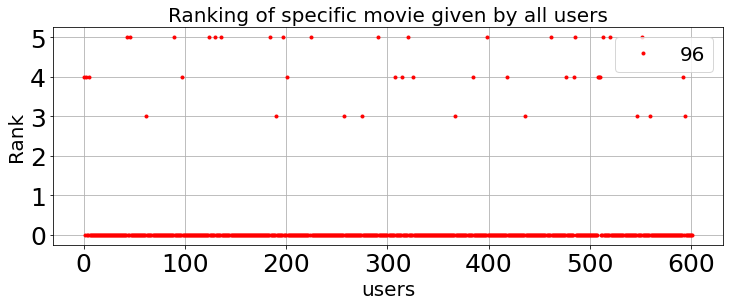

In [165]:
plt.figure(figsize=(12, 4))
plt.plot(aa[:,602], "r.",label= np.count_nonzero(aa[:,602]))
plt.ylabel('Rank', fontsize=20)
plt.xlabel('users', fontsize=20)
plt.grid()
plt.legend()
plt.legend(loc = 1, fontsize=20)
plt.xticks(size = 25)
plt.yticks(size = 25)

plt.title('Ranking of specific movie given by all users', fontsize=20)
plt.savefig('Ranking.jpeg')


In [5]:
import time
from scipy.sparse.linalg import svds

In [6]:
def svt_feature(mat,
                M = None,
                svd_k = 100,#Top k largest singular values
                svd_maxiter = 100,#The maximal number of iterations for svd
                svt_delta = 0.5,#The learning rate for SVT
                e=0.0001,# Error rate bound for stopping iteration
                svt_maxiter=100#The maximal number of iterations for SVT
               ):    

    if M is None :
        idx1 = np.where(mat!=0)[0]
        idx2 = np.where(mat!=0)[1]
        M = mat[idx1, idx2]
    else:
        idx1 = np.array(M[:,0], dtype='int')
        idx2 = np.array(M[:,1], dtype='int')
        M = M[:,2]
    tic = time.time()
    # Efficient svd implementation from scipy
    U,s,V = svds(mat, k = svd_k, maxiter = svd_maxiter)
    loop = 0
    i = 0
    err = 100    # Initial error set a large number
    # First svd approximation
    Y = U.dot(np.diag(s)).dot(V)
    while err > e and i <= svt_maxiter:
        Y[idx1, idx2] += svt_delta * (M - Y[idx1, idx2])
        U,s,V = svds(Y, k = svd_k, maxiter=svd_maxiter)
        Y = U.dot(np.diag(s)).dot(V)
        i += 1
        err = np.sum((M - Y[idx1, idx2])**2) / np.sum(M**2)
        if i % 10 == 0:
            c = np.corrcoef(U.dot(np.diag(np.sqrt(s))))

    X = U.dot(np.diag(np.sqrt(s)))
    return X,Y
sigma, prediction = svt_feature(aa.T)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [7]:
print(prediction.shape)
print(aa.T.shape)

(9700, 609)
(9700, 609)


In [8]:
for each in range(len(prediction)):
    prediction[each].T[prediction[each].T<0]=0.5

In [9]:
A = np.reshape(aa.T, aa.T.shape[0] * aa.T.shape[1])
B = np.reshape(prediction, prediction.shape[0] * prediction.shape[1])
C = []
for i , j in zip(A, B):
    if i != 0 :
        C.append(i)
    else:
        C.append(j)

the list C is our prediction such that, where initial rating matrix had value as rating, we keep them and where it had zero (mask) we replase that values by SVT's predicted value.Butwe will not use C :)

In [10]:
A = A.reshape(aa.T.shape[0], aa.T.shape[1])

B = B.reshape(prediction.shape[0], prediction.shape[1])

In [11]:
print(A.shape)# A is aa.T
print(B.shape)#B is predction


(9700, 609)
(9700, 609)


In [12]:
print("norm for original matrix: ",np.linalg.norm(A, "nuc"))
print("norm for SVT            : ",np.linalg.norm(B, "nuc"))

norm for original matrix:  20415.3999053824
norm for SVT            :  22359.12107092115


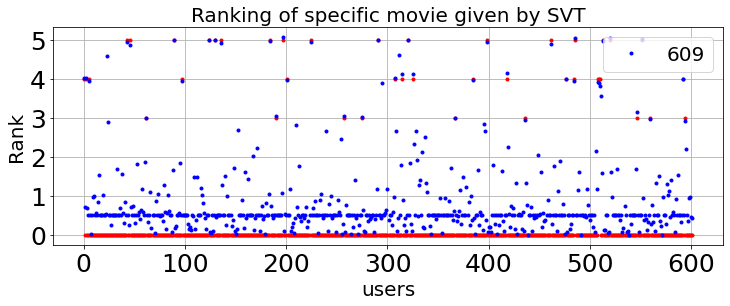

In [163]:
#lets take a look at first 20 rates that we got so far 

plt.figure(figsize=(12, 4))
plt.plot(A.T[0][:602], 'r.') 
plt.plot(B.T[0][:602],'b.', label= np.count_nonzero(B.T[:,602]))
plt.title('Ranking of specific movie given by SVT', fontsize=20)
plt.ylabel('Rank', fontsize=20)
plt.xlabel('users', fontsize=20)
plt.legend(loc = 1, fontsize=20)
plt.xticks(size = 25)
plt.yticks(size = 25)
plt.grid()
plt.savefig('SVT_Ranking.jpeg')


In [14]:
B_T = [i[0] for i in sorted(enumerate(B.T[0]), key=lambda x:x[1])]
B_T_inv = B_T[::-1]
B_ = [i[0] for i in sorted(enumerate(B[0]), key=lambda x:x[1])]
B_inv = B_[::-1]

In [15]:
data_set_movies = pd.read_csv("ml-latest-small/movies.csv")
data_set_movies["title"]

0                                Toy Story (1995)
1                                  Jumanji (1995)
2                         Grumpier Old Men (1995)
3                        Waiting to Exhale (1995)
4              Father of the Bride Part II (1995)
                          ...                    
9737    Black Butler: Book of the Atlantic (2017)
9738                 No Game No Life: Zero (2017)
9739                                 Flint (2017)
9740          Bungo Stray Dogs: Dead Apple (2018)
9741          Andrew Dice Clay: Dice Rules (1991)
Name: title, Length: 9742, dtype: object

In [16]:
movies = data_set_movies["title"][:9700].tolist()

In [17]:
# col_one_list = data_set_movies["title"][:9700].tolist()
print("our prediction for user_0")
print("")
j = 0
for i in B_T:
    j+=1
    #lets show high rate predicted movies
    if B.T[0][i] > 4.9:
        # without rounding rates
        print(j,"movie name", "--", movies[i], "___","its index", "--",B.T[0][i])
#         #with rounded rates
#         print(j, "movie name", "-----", movies[i], "______","predicted rate", "-----", np.round(B.T[0][i]))

our prediction for user_0

9584 movie name -- Sophie's Choice (1982) ___ its index -- 4.9074498047624955
9585 movie name -- Star Wars: Episode V - The Empire Strikes Back (1980) ___ its index -- 4.915183803254209
9586 movie name -- Desperado (1995) ___ its index -- 4.920276789933826
9587 movie name -- Peacemaker, The (1997) ___ its index -- 4.935714390262936
9588 movie name -- Yellow Submarine (1968) ___ its index -- 4.938408602109482
9589 movie name -- Star Wars: Episode IV - A New Hope (1977) ___ its index -- 4.938655681273155
9590 movie name -- Fugitive, The (1993) ___ its index -- 4.948786842343218
9591 movie name -- Rosemary's Baby (1968) ___ its index -- 4.950994070782463
9592 movie name -- Seven (a.k.a. Se7en) (1995) ___ its index -- 4.9631306452574
9593 movie name -- Citizen Kane (1941) ___ its index -- 4.963256572778932
9594 movie name -- Godfather: Part II, The (1974) ___ its index -- 4.963809468669935
9595 movie name -- Agnes of God (1985) ___ its index -- 4.9640243052030515

In [18]:
print("our prediction for user_0")
print("")
j = 0
for i in B_T:
    j+=1
    
    if B.T[0][i] > 4.9:
#         print("movie index", "-----", BB_inv[i], "______","predicted rate", "-----",B[0][i])
        print(j, "movie index", "-----", B_T_inv[i], "______","predicted rate", "-----", np.round(B.T[0][i]))

our prediction for user_0

9584 movie index ----- 9574 ______ predicted rate ----- 5.0
9585 movie index ----- 233 ______ predicted rate ----- 5.0
9586 movie index ----- 1644 ______ predicted rate ----- 5.0
9587 movie index ----- 8724 ______ predicted rate ----- 5.0
9588 movie index ----- 8680 ______ predicted rate ----- 5.0
9589 movie index ----- 615 ______ predicted rate ----- 5.0
9590 movie index ----- 1791 ______ predicted rate ----- 5.0
9591 movie index ----- 9551 ______ predicted rate ----- 5.0
9592 movie index ----- 1754 ______ predicted rate ----- 5.0
9593 movie index ----- 6539 ______ predicted rate ----- 5.0
9594 movie index ----- 3201 ______ predicted rate ----- 5.0
9595 movie index ----- 8167 ______ predicted rate ----- 5.0
9596 movie index ----- 1558 ______ predicted rate ----- 5.0
9597 movie index ----- 8678 ______ predicted rate ----- 5.0
9598 movie index ----- 361 ______ predicted rate ----- 5.0
9599 movie index ----- 8562 ______ predicted rate ----- 5.0
9600 movie index

In [19]:

indexes = B_T_inv
main_list_m = movies
main_list_r = B.T[0]
rates_0 = [main_list_r[x] for x in indexes]
movies_0 = [main_list_m[x] for x in indexes]

In [20]:

User_0 = {'movies': movies_0,
        'predicted_rank': rates_0
        }

df = pd.DataFrame(User_0, columns = ['movies', 'predicted_rank'])

print (df)

                                     movies  predicted_rank
0                         Yards, The (2000)        5.281029
1     Cheech and Chong's Up in Smoke (1978)        5.230158
2                 Lawrence of Arabia (1962)        5.223639
3                Princess Bride, The (1987)        5.142798
4               Arsenic and Old Lace (1944)        5.130289
...                                     ...             ...
9695              Star Trek: Nemesis (2002)        0.000000
9696                      Panic Room (2002)        0.000000
9697               Coming to America (1988)        0.000000
9698      Slumber Party Massacre III (1990)        0.000000
9699                  Get on the Bus (1996)        0.000000

[9700 rows x 2 columns]


In [21]:
compression_opts = dict(method='zip',

                        archive_name='out.csv')  

df.to_csv('out.zip', index=True,

          compression=compression_opts) 

In [151]:
for i in range(len(aa)):
    if aa.T[0][i] != 0:
        print(i,"-----", aa.T[0][i])

0 ----- 4.0
4 ----- 4.0
6 ----- 4.5
14 ----- 2.5
16 ----- 4.5
17 ----- 3.5
18 ----- 4.0
20 ----- 3.5
26 ----- 3.0
30 ----- 5.0
31 ----- 3.0
32 ----- 3.0
39 ----- 5.0
42 ----- 5.0
43 ----- 3.0
44 ----- 4.0
45 ----- 5.0
49 ----- 3.0
53 ----- 3.0
56 ----- 5.0
62 ----- 5.0
63 ----- 4.0
65 ----- 4.0
67 ----- 2.5
70 ----- 5.0
72 ----- 4.5
75 ----- 0.5
77 ----- 4.0
81 ----- 2.5
85 ----- 4.0
88 ----- 3.0
89 ----- 3.0
90 ----- 4.0
92 ----- 3.0
95 ----- 5.0
97 ----- 4.5
102 ----- 4.0
106 ----- 4.0
111 ----- 3.0
118 ----- 3.5
120 ----- 4.0
123 ----- 4.0
129 ----- 3.0
131 ----- 2.0
133 ----- 3.0
134 ----- 4.0
136 ----- 4.0
139 ----- 3.0
140 ----- 4.0
143 ----- 3.5
144 ----- 5.0
150 ----- 5.0
152 ----- 2.0
154 ----- 3.0
155 ----- 4.0
158 ----- 4.5
159 ----- 4.0
160 ----- 4.0
165 ----- 5.0
166 ----- 3.5
168 ----- 4.5
170 ----- 5.0
176 ----- 5.0
177 ----- 4.0
178 ----- 4.0
181 ----- 4.0
184 ----- 4.0
185 ----- 4.0
190 ----- 4.0
192 ----- 2.0
199 ----- 3.5
200 ----- 5.0
201 ----- 4.0
205 ----- 5.0
212

In [82]:
def pepper_salt_noise(p,image):
    m, n = image.shape
    frac = 1- p
    sample = np.random.binomial(1, frac, size=m*n)
    mask = np.reshape(sample, (m, n))
    image_noise = image * mask
    return mask, image_noise

In [98]:
img = aa.T
mask, image_noise = pepper_salt_noise(0.1, img)

In [99]:
sigma, prediction = svt_feature(image_noise)

In [161]:
for i in range(len(prediction)):
    if aa.T[0][i] != 0:
        print(i,":", "actual rate","--", aa.T[0][i],"________","prediction:","--", np.round(prediction[0][i]) )

0 : actual rate -- 4.0 ________ prediction: -- 4.0
4 : actual rate -- 4.0 ________ prediction: -- 4.0
6 : actual rate -- 4.5 ________ prediction: -- 3.0
14 : actual rate -- 2.5 ________ prediction: -- 2.0
16 : actual rate -- 4.5 ________ prediction: -- 4.0
17 : actual rate -- 3.5 ________ prediction: -- 4.0
18 : actual rate -- 4.0 ________ prediction: -- 4.0
20 : actual rate -- 3.5 ________ prediction: -- 3.0
26 : actual rate -- 3.0 ________ prediction: -- 3.0
30 : actual rate -- 5.0 ________ prediction: -- 5.0
31 : actual rate -- 3.0 ________ prediction: -- 3.0
32 : actual rate -- 3.0 ________ prediction: -- 3.0
39 : actual rate -- 5.0 ________ prediction: -- 5.0
42 : actual rate -- 5.0 ________ prediction: -- 5.0
43 : actual rate -- 3.0 ________ prediction: -- 3.0
44 : actual rate -- 4.0 ________ prediction: -- 4.0
45 : actual rate -- 5.0 ________ prediction: -- 5.0
49 : actual rate -- 3.0 ________ prediction: -- 3.0
53 : actual rate -- 3.0 ________ prediction: -- 3.0
56 : actual rat

IndexError: index 609 is out of bounds for axis 0 with size 609

In [103]:
error = np.sum(((np.round( prediction[0]) - aa.T[0])**2))/ len(aa[0])
error

0.1602577319587629